In [348]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import pickle
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tensorflow import keras

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)


In [84]:
season = "2021-22"
sbs = pd.read_csv(data_dir / "score_by_score" / (eval_season + ".csv"))
playstats = pd.read_csv(data_dir / "playstats" / (eval_season + ".csv"))
rankings = pd.read_csv(data_dir / "rankings" / (eval_season + ".csv"))


In [86]:
model = keras.models.load_model(hoops_dir / "model/models/16_32_8|2|3|2.5e-06|home_lead_time_left_home_ranking_vis_ranking_home_lead_pml")
scaler = pickle.load(open(hoops_dir / "model/scalers/16_32_8|2|3|2.5e-06|home_lead_time_left_home_ranking_vis_ranking_home_lead_pml", "rb"))


In [87]:
sbs_reg = sbs.loc[sbs['time'] < 48].copy(deep=True)
features = ['home_lead', 'log_time_left', 'home_ranking', 'vis_ranking', 'home_lead_per_root_minute']
sbs_reg['home_lead'] = sbs_reg['home_score'] - sbs_reg['vis_score']
sbs_reg['log_time_left'] = np.log(48 - sbs_reg['time'])
sbs_reg['ppm'] = (sbs_reg['home_score'] + sbs_reg['vis_score']) / sbs_reg['time']
sbs_reg['home_lead_per_root_minute'] = sbs_reg['home_lead'] / np.sqrt(48-sbs_reg['time'])


In [117]:
sbs_reg.loc[(sbs_reg['home'] == "MIA") | (sbs_reg['vis'] == "MIA")].drop_duplicates('game_id').sort_values("date")

,game_id,date,home,vis,time,home_score,vis_score,home_win,home_lead,log_time_left,ppm,home_lead_per_root_minute
97517,22100015,2021-10-21,MIA,MIL,0.0,0,0,True,0,3.871201,NaN,0.0
96368,22100028,2021-10-23,IND,MIA,0.0,0,0,True,0,3.871201,NaN,0.0
57760,22100045,2021-10-25,MIA,ORL,0.0,0,0,True,0,3.871201,NaN,0.0
42509,22100057,2021-10-27,BKN,MIA,0.0,0,0,False,0,3.871201,NaN,0.0
78122,22100073,2021-10-29,MIA,CHA,0.0,0,0,True,0,3.871201,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
70944,22100922,2022-02-28,MIA,CHI,0.0,0,0,True,0,3.871201,NaN,0.0
71056,22100936,2022-03-02,MIL,MIA,0.0,0,0,True,0,3.871201,NaN,0.0
96598,22100941,2022-03-03,BKN,MIA,0.0,0,0,False,0,3.871201,NaN,0.0
90681,22100956,2022-03-05,MIA,PHI,0.0,0,0,True,0,3.871201,NaN,0.0


In [345]:
gameid = 22100941
game_sbs = sbs_reg.loc[sbs_reg['game_id'] == gameid].reset_index(drop=True).copy(deep=True)
home, vis, game_date = game_sbs.iloc[0][['home', 'vis', 'date']]
home_ranking = rankings.loc[(rankings['date'] == game_date) & (rankings['team'] == home), 'ranking']
vis_ranking = rankings.loc[(rankings['date'] == game_date) & (rankings['team'] == vis), 'ranking']
game_sbs['home_ranking'] = home_ranking.iloc[0]
game_sbs['vis_ranking'] = vis_ranking.iloc[0]
game_features = scaler.transform(game_sbs[features].to_numpy())
home_probs = model.predict(game_features)[:,0].round(3)


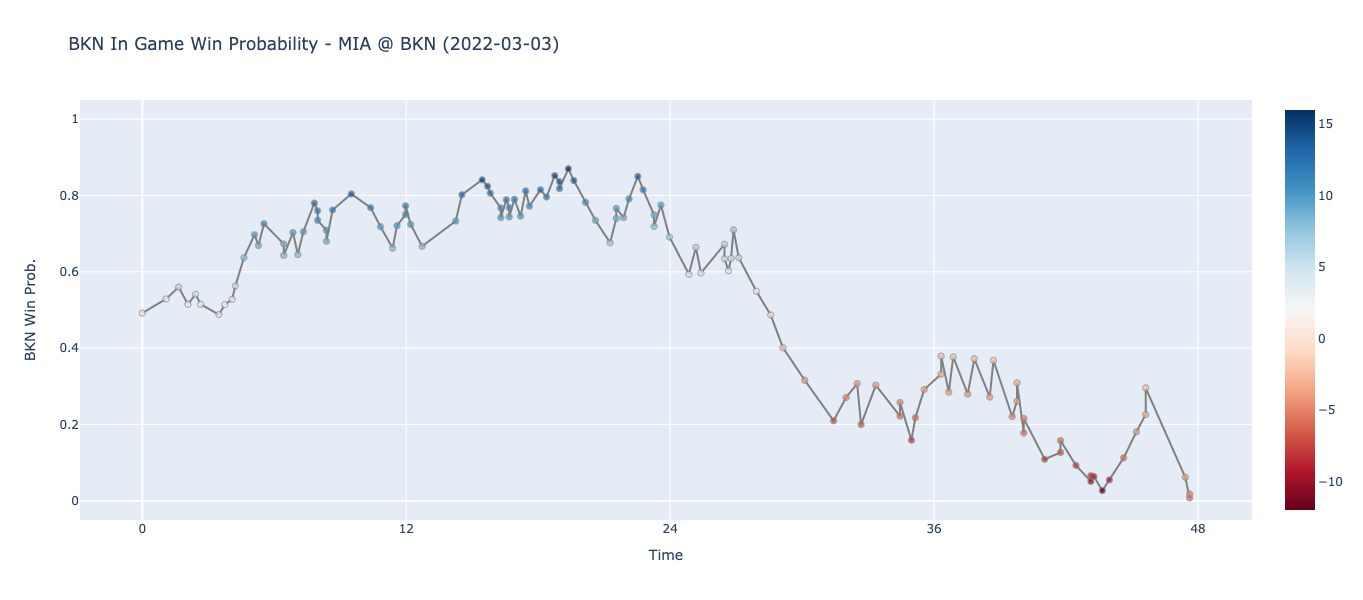

In [346]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=game_sbs['time'], y=home_probs, line_color="gray", name="", mode='lines', showlegend=False))
fig.add_trace(go.Scatter(x=game_sbs['time'], y=home_probs, name="", mode='markers', marker_showscale=True, showlegend=False,
                         marker_color=game_sbs['home_lead'], marker_colorscale="RdBu", marker_size=6, marker_opacity=0.75, marker_line_width=1, marker_line_color="gray"))
fig.update_layout(width=1000, height=600)
fig.update_layout(legend_title_text = "Legend Label")
fig.update_layout(title=f"{home} In Game Win Probability - {vis} @ {home} ({game_date})",)
fig.update_layout(coloraxis_colorbar={'title': f"{home} Lead"}) # TODO: why doesn't this work (note; could also add home lead as a label in the clickable thing)
fig.update_xaxes(title_text="Time")
fig.update_yaxes(title_text=f"{home} Win Prob.", range=(-.05, 1.05))
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 12
    )
)
fig.show()


In [349]:
pio.write_html(fig, file='_includes/figure.html', auto_open=False)